In [1]:
import stageemi.dev.decorator_map as dm
import xarray as xr 
import ipywidgets as widg
import ipyleaflet as ipyl
import datetime as dt
import os 
import numpy as np
import shapely
from stageemi.dev.visu import Borders,Map
import geojson
from ipyleaflet import WidgetControl,LayersControl,Marker, Popup
import pandas 
import glob


In [2]:

def conversion(ds):
    """convert wwmf code into wme code"""
    file_CodesWWMF= '../../utils/CodesWWMF.csv'
    df_WWMF = pandas.read_csv(file_CodesWWMF,usecols = (0,1,6,7),sep=',')
    
    ds["wme_arr"]=ds.unknown

    for iwwmf,wwmf in enumerate(df_WWMF["Code WWMF"]):
        ds["wme_arr"]=ds["wme_arr"].where(ds.unknown!=wwmf,df_WWMF["Code WME"][iwwmf])
        
    return ds

In [ ]:
var2plot = "WWMF"
mask =  '38'#'38' #['FRB05',"FRH02",'FRJ13','FRK24']
date = "2019110400"
# date   = '2019122100'

mask = '34'
date = '2020012600'#'2020011900'

# dir_in = '/scratch/labia/lepapeb/StageEMI/'+var2plot+'/'
dir_in = 'C:\\Users\\mary\\Desktop\\stageemi\\'

fname  = dir_in + date+'0000__PG0PAROME__'+var2plot+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
ds     = xr.open_dataset(fname)
ds['latitude']  = ds['latitude'].round(5)
ds['longitude'] = ds['longitude'].round(5)
ds = conversion(ds)
print(fname)

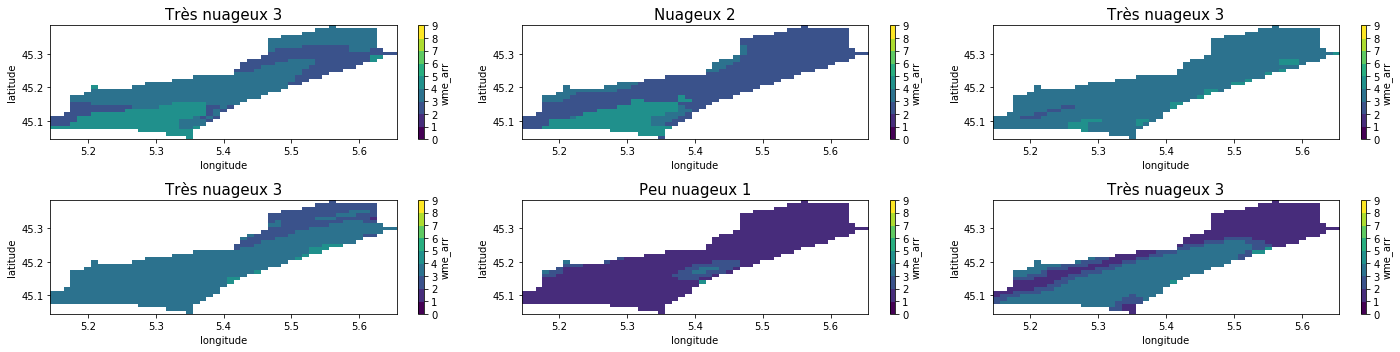

In [4]:
# Lecture des codes WWMF pour chercher le temps majoritaire
file_CodesWWMF = '/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/utils/CodesWWMF.csv'
df = pandas.read_csv(file_CodesWWMF,usecols = (0,1),sep=',')
legende_WWMF = df['Legende WWMF'].to_numpy()
code_WWMF    = df['Code WWMF'].to_numpy()

subzone     = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO/3808.nc'
ds_mask_sub = xr.open_dataset(subzone)
ds_mask_sub["latitude"]=ds_mask_sub["latitude"].round(5)
ds_mask_sub["longitude"]=ds_mask_sub["longitude"].round(5)
data = ds_mask_sub["mask"].isel(id=0) * ds



def  WWMF_majoritaire(data, code_WWMF,legende_WWMF):
    occurence_WWMF   = np.asarray([np.sum(data == code_WWMF[i]) for i in range(code_WWMF.size)])
    WWMF_code_majoritaire = code_WWMF[occurence_WWMF.argmax()]
    WWMF_leg_majoritaire  = legende_WWMF[occurence_WWMF.argmax()]
#     print(np.sort(occurence_WWMF)[::-1])
#     print(np.argsort(occurence_WWMF)[::-1])
    return WWMF_code_majoritaire, WWMF_leg_majoritaire

import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=2,ncols = 3,figsize=(20,5))
ax = axes.flat
for i,istep in enumerate(range(0,24,4)):
#     val = data['unknown'].isel(step=istep).copy()
    val = data['wme_arr'].isel(step=istep).copy()
    code,leg = WWMF_majoritaire(val.values, code_WWMF,legende_WWMF)
    val.plot.imshow(ax=ax[i],levels=range(0,10))
    ax[i].set_title(leg+' ' + str(code),fontsize=15)

fig.tight_layout()
# fig.savefig('/home/mrpa/borderiesm/stageEMI/fig/'+date +ds_mask_sub["mask"].attrs["name"]+ '.png',dpi=400)
# plt.clf()
# plt.close('all')

In [3]:
# pour ploter: 
@dm.gogeojson_wwmf(type="Pixel")
def get_step(data,step):
    return data["unknown"].isel(step=step)

def update_html(feature, **kwargs):
    #print('kwarg',kwargs)
    #print(geojson_layer.name)
    #temps_maj = 'toto' #kwargs['kwarg1']
    #print('temps prevu',temps_maj)
    
    
    file_CodesWWMF = '/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/utils/CodesWWMF.csv'
    df = pandas.read_csv(file_CodesWWMF,usecols = (0,1),sep=',')
    legende_WWMF = df['Legende WWMF'].to_numpy()
    code_WWMF    = df['Code WWMF'].to_numpy()
    valeur_code  = feature['properties']['value']
    indice       = np.where(code_WWMF == valeur_code)
    html1.value = '''
        <h4> Type de temps </h4>
        <h4><b>{}<br />{}<br /></h4>
    '''.format(legende_WWMF[indice[0]][0],code_WWMF[indice[0]][0])
    

def on_change(change):
    code,legende_majoritaire = WWMF_majoritaire(data['unknown'].isel(step=change["new"]).values, code_WWMF,legende_WWMF)
    print(legende_majoritaire)
    geo_file,legend_file = get_step(data,change["new"])
    geojson_layer = ipyl.GeoJSON(data=geo_file,hover_style={"opacity":1},name=ds_mask_sub["mask"].attrs["name"]+' '+legende_majoritaire)
    if len(m.layers) == 1:
        m.add_layer(geojson_layer)
    else: 
        m.substitute_layer(m.layers[3],geojson_layer)
    geojson_layer.on_hover(update_html)

    legend_file.seek(0)
    legend.value =legend_file.read() 
    

slider = widg.IntSlider(min=0,max=len(ds.step),step=1,value=0,description="step")
slider.observe(on_change,'value')
    
    

NameError: name 'ds' is not defined

In [6]:
m = ipyl.Map(zoom=9, center=(45,6)) #center=(lat_center,lon_center ))

ZonesSympo_layer= Borders('/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/ZonesSympo/zones_sympo_4326.json',
                          color='blue',name="sympo")
m.add_layer(ZonesSympo_layer)
if mask == "FRJ13":
    dept= Borders('/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/Departements/Herault.json',color='red')
    m.add_layer(dept)
if mask == "FRK24":
    dept = Borders('/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/Departements/Isere.json',color='red')
    m.add_layer(dept)
if mask == "29":
    dept = Borders('/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/Departements/Finistere.json',color='red')
    m.add_layer(dept)
dept = Borders('/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/Departements/Isere.json',color='red')
m.add_layer(dept)

    
html1 = widg.HTML('''
    <h4>Type de temps</h4>
    Hover over a pixel
''')
html1.layout.margin = '0px 20px 20px 20px'
control1 = WidgetControl(widget=html1, position='bottomright')
m.add_control(control1)
m.add_control(ipyl.WidgetControl(widget=slider,position="topright"))


# plot des masks
dir_mask = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO/'
list_subzones = glob.glob(dir_mask + mask+'*.nc')
#print(list_subzones)
for isub,subzone in enumerate(list_subzones):
    try:
        ds_mask_sub = xr.open_dataset(subzone)
    #    lecture et selection des champs juste sur le mask
        ds_mask_sub["latitude"]=ds_mask_sub["latitude"].round(5)
        ds_mask_sub["longitude"]=ds_mask_sub["longitude"].round(5)
        data = ds_mask_sub["mask"].isel(id=0) * ds
        
        # temps majoritaire
        code,legende_majoritaire = WWMF_majoritaire(data['unknown'].isel(step=0).values, code_WWMF,legende_WWMF)
        geo_file,legend_file = get_step(data,0)
        geojson_layer = ipyl.GeoJSON(data=geo_file,hover_style={"opacity":0,"fillColor":"#000000"},
                                     name=ds_mask_sub["mask"].attrs["name"]+' '+ds_mask_sub.mask.id.values[0])
        
        #geojson_layer.on_hover(update_html(geojson_layer.data["features"][0]["properties"]['value'],
         #                                 kwarg1=legende_majoritaire))
        geojson_layer.on_hover(update_html)
       # print(geojson_layer.data["features"][:]["properties"]['value'])
        #print(geojson_layer.name)
        
        
        m.add_layer(geojson_layer)
        
        
    except(FileNotFoundError): 
        print(subzone,"existe pas")
m.add_control(LayersControl(position='topleft'))


/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/preproc2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarn

In [12]:
ds_mask_sub.mask.id.values[0]
#m.add_layer(geojson_layer)

'3483'

In [7]:
legend_file.seek(0)
legend = widg.Image(layout=widg.Layout(height="430px"))
legend.value = legend_file.read() 
widg_map = widg.HBox([m,legend])
widg_map